## Import librari

In [40]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import time
from IPython import display


# Download and read file entities

In [69]:
dataset_url = "https://raw.githubusercontent.com/AndiAlifs/sistem_cerdas_chatbot_selma/master/ori_dataset/entities.json"

In [70]:
import requests

# request to the url and get the response
response = requests.get(dataset_url)

# read the json file
data = response.json()

# Splitting file entities

In [43]:
data_selksiMasuk = data['entities']['seleksi_masuk']
data_fakultas = data['entities']['fakultas']
data_prodi = data['entities']['prodi']

In [44]:
tag = []
patterns = []

for i in data_selksiMasuk:
    for pattern in i['pattern']:
        tag.append(i['tag'])
        patterns.append(pattern)

dfSeleksiMasuk = pd.DataFrame({'tag': tag, 'patterns': patterns})

In [45]:
tag = []
patterns = []

for i in data_fakultas:
    for pattern in i['pattern']:
        tag.append(i['tag'])
        patterns.append(pattern)

dfFakultas = pd.DataFrame({'tag': tag, 'patterns': patterns})

In [46]:
tag = []
patterns = []

for i in data_prodi:
    for pattern in i['pattern']:
        tag.append(i['tag'])
        patterns.append(pattern)

dfProdi = pd.DataFrame({'tag': tag, 'patterns': patterns})

In [47]:
# preprocessing data text
import re

def preprocessing_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = text.strip()
    return text

In [48]:
#make callbacks when model accurcay hit 90%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.9):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [50]:
def get_feature_names(vectorizer):
    feature_names = vectorizer.get_feature_names()
    return feature_names

# Training entiti recognition for seleksimasuk

In [51]:
# training model for seleksiMasuk
vectorizerSlekMasuk = TfidfVectorizer()
X = vectorizerSlekMasuk.fit_transform(dfSeleksiMasuk['patterns'].apply(preprocessing_text))
X = X.toarray()
Y = dfSeleksiMasuk['tag'].values

classCount = len(np.unique(Y))

label_encoderSeleksiMasuk = LabelEncoder()
integer_encoded = label_encoderSeleksiMasuk.fit_transform(Y)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y = onehot_encoder.fit_transform(integer_encoded)

X_train = X
y_train = Y

take = 0.2
x_test = X_train[:int(len(X_train)*take)]
y_test = y_train[:int(len(y_train)*take)]

modelForSeleksiMasuk = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(classCount, activation='softmax'),
])

modelForSeleksiMasuk.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

callbacks = myCallback()

history = modelForSeleksiMasuk.fit(X_train, y_train,
                        validation_data=(x_test, y_test),epochs=100, callbacks=[callbacks])

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.9512 - accuracy: 0.0000e+00 - val_loss: 1.9294 - val_accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 193ms/step - loss: 1.9354 - accuracy: 0.2000 - val_loss: 1.9203 - val_accuracy: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 81ms/step - loss: 1.9217 - accuracy: 0.3500 - val_loss: 1.9128 - val_accuracy: 0.5000
Epoch 4/100
1/1 [==============================] - 0s 58ms/step - loss: 1.9089 - accuracy: 0.4000 - val_loss: 1.9050 - val_accuracy: 0.5000
Epoch 5/100
1/1 [==============================] - 0s 61ms/step - loss: 1.8969 - accuracy: 0.5000 - val_loss: 1.8979 - val_accuracy: 0.7500
Epoch 6/100
1/1 [==============================] - 0s 70ms/step - loss: 1.8860 - accuracy: 0.6500 - val_loss: 1.8909 - val_accuracy: 0.7500
Epoch 7/100
1/1 [==============================] - 0s 111ms/step - loss: 1.8746 - accuracy: 0.6500 - val_loss: 1.8834 - val_accuracy: 0.7500
Epoch 8/100
1/1 

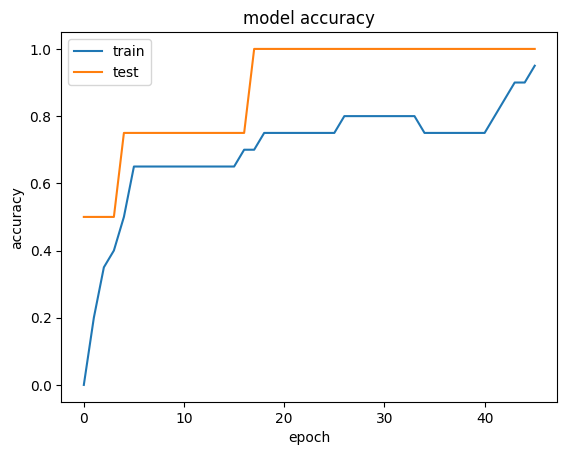

In [52]:
# plot the model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

Text(0.5, 0, 'epoch')

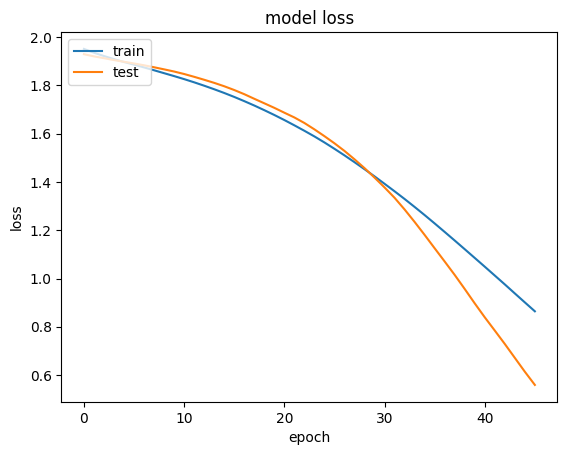

In [53]:
# plot the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [54]:
# display processed vectorizerSlekMasuk
dfSeleksiMasukVector = pd.DataFrame(X_train, columns=get_feature_names(vectorizerSlekMasuk))
dfSeleksiMasukVector.index = dfSeleksiMasuk['patterns']
dfSeleksiMasukVector.style.background_gradient(cmap='gray_r')


c:\Users\AndiAlif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,afirmasi,bersama,jalur,khusus,lainnya,mandiri,nasional,nilai,prestasi,rapor,reguler,sbmptn,seleksi,snmptn,undangan,utbk
patterns,,,,,,,,,,,,,,,,
seleksi nasional,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.751080,0.000000,0.000000,0.000000,0.000000,0.000000,0.660211,0.000000,0.000000,0.000000
snmptn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
jalur undangan,0.000000,0.000000,0.440977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.897519,0.000000
jalur prestasi,0.000000,0.000000,0.440977,0.000000,0.000000,0.000000,0.000000,0.000000,0.897519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
seleksi bersama,0.000000,0.751080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.660211,0.000000,0.000000,0.000000
sbmptn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
utbk,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
afirmasi,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
jalur khusus,0.000000,0.000000,0.487908,0.872895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Training entiti recognition for fakultas

In [55]:
# training model for fakultas
vectorizerFakultas = TfidfVectorizer()
X = vectorizerFakultas.fit_transform(dfFakultas['patterns'].apply(preprocessing_text))
X = X.toarray()
Y = dfFakultas['tag'].values

classCount = len(np.unique(Y))

label_encoderFakultas = LabelEncoder()
integer_encoded = label_encoderFakultas.fit_transform(Y)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y = onehot_encoder.fit_transform(integer_encoded)

X_train = X
y_train = Y

take = 0.2
x_test = X_train[:int(len(X_train)*take)]
y_test = y_train[:int(len(y_train)*take)]

modelForFakultas = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(classCount, activation='softmax'),
])

modelForFakultas.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

callbacks = myCallback()

history = modelForFakultas.fit(X_train, y_train,
                        validation_data=(x_test, y_test),epochs=100, callbacks=[callbacks])

Epoch 1/100
2/2 [==============================] - 2s 387ms/step - loss: 2.6420 - accuracy: 0.0208 - val_loss: 2.6814 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 53ms/step - loss: 2.6246 - accuracy: 0.0625 - val_loss: 2.6654 - val_accuracy: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 0s 57ms/step - loss: 2.6114 - accuracy: 0.0625 - val_loss: 2.6551 - val_accuracy: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 0s 52ms/step - loss: 2.5991 - accuracy: 0.1042 - val_loss: 2.6454 - val_accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 50ms/step - loss: 2.5869 - accuracy: 0.1250 - val_loss: 2.6366 - val_accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 57ms/step - loss: 2.5738 - accuracy: 0.1875 - val_loss: 2.6289 - val_accuracy: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 0s 72ms/step - loss: 2.5601 - accuracy: 0.2292 - val_loss: 2.6213 - val_accuracy: 0.

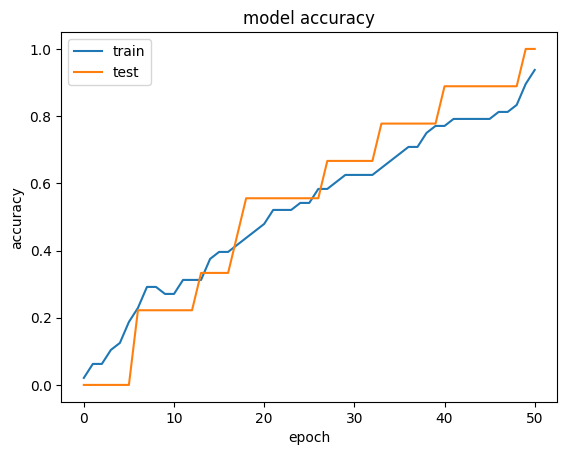

In [56]:
# plot the accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

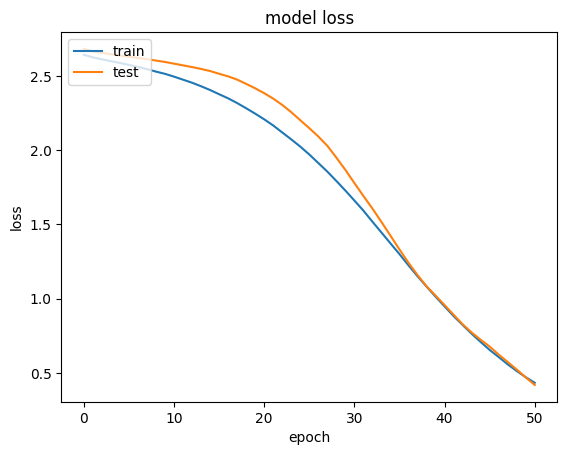

In [57]:
# plot the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [58]:
# display processed vectorizerFakultas
dfFakultasVector = pd.DataFrame(X_train, columns=get_feature_names(vectorizerFakultas))
dfFakultasVector.index = dfFakultas['patterns']
dfFakultasVector.style.background_gradient(cmap='gray_r')

c:\Users\AndiAlif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,administrasi,admnistrai,bisnis,dan,diploma,ekonomi,fakultas,fapet,feb,fh,fia,filkom,fisip,fk,fkg,fkh,fp,fpik,ft,ftp,gigi,hewan,hukum,ilmu,kedokteran,kelautan,komputer,perikanan,pertanian,peternakan,politik,sosial,teknik,teknologi,vokasi
patterns,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
fakultas ilmu komputer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.435776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.521244,0.000000,0.000000,0.733760,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
filkom,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ilmu komputer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.579125,0.000000,0.000000,0.815239,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fakultas ilmu sosial dan ilmu politik,0.000000,0.000000,0.000000,0.375094,0.000000,0.000000,0.272575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.652069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.424154,0.424154,0.000000,0.000000,0.000000
fisip,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ilmu sosial dan ilmu politik,0.000000,0.000000,0.000000,0.389856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.677732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.440847,0.440847,0.000000,0.000000,0.000000
sosial,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
politik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
fk,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Training entiti recognition for prodi

In [59]:
#training for prodi
vectorizerProdi = TfidfVectorizer()
X = vectorizerProdi.fit_transform(dfProdi['patterns'].apply(preprocessing_text))
X = X.toarray()
Y = dfProdi['tag'].values

classCount = len(np.unique(Y))

label_encoderProdi = LabelEncoder()
integer_encoded = label_encoderProdi.fit_transform(Y)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

Y = onehot_encoder.fit_transform(integer_encoded)

X_train = X
y_train = Y

take = 0.2

x_test = X_train[:int(len(X_train)*take)]
y_test = y_train[:int(len(y_train)*take)]

modelForProdi = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(classCount, activation='sigmoid'),
])

modelForProdi.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

callbacks = myCallback()

history = modelForProdi.fit(X_train, y_train,
                        validation_data=(x_test, y_test),epochs=150, callbacks=[callbacks])
                        

Epoch 1/150
2/2 [==============================] - 2s 240ms/step - loss: 0.6878 - accuracy: 0.0635 - val_loss: 0.6772 - val_accuracy: 0.0000e+00
Epoch 2/150
2/2 [==============================] - 0s 65ms/step - loss: 0.6730 - accuracy: 0.0476 - val_loss: 0.6621 - val_accuracy: 0.0000e+00
Epoch 3/150
2/2 [==============================] - 0s 53ms/step - loss: 0.6582 - accuracy: 0.0317 - val_loss: 0.6458 - val_accuracy: 0.0000e+00
Epoch 4/150
2/2 [==============================] - 0s 56ms/step - loss: 0.6421 - accuracy: 0.0317 - val_loss: 0.6273 - val_accuracy: 0.0000e+00
Epoch 5/150
2/2 [==============================] - 0s 41ms/step - loss: 0.6237 - accuracy: 0.0317 - val_loss: 0.6060 - val_accuracy: 0.0000e+00
Epoch 6/150
2/2 [==============================] - 0s 36ms/step - loss: 0.6020 - accuracy: 0.0317 - val_loss: 0.5817 - val_accuracy: 0.0000e+00
Epoch 7/150
2/2 [==============================] - 0s 37ms/step - loss: 0.5771 - accuracy: 0.0317 - val_loss: 0.5539 - val_accuracy: 0.

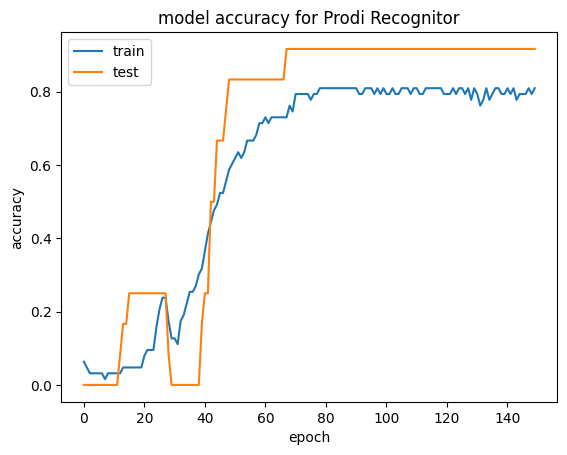

In [60]:
# plot the model akurasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('model accuracy for Prodi Recognitor')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


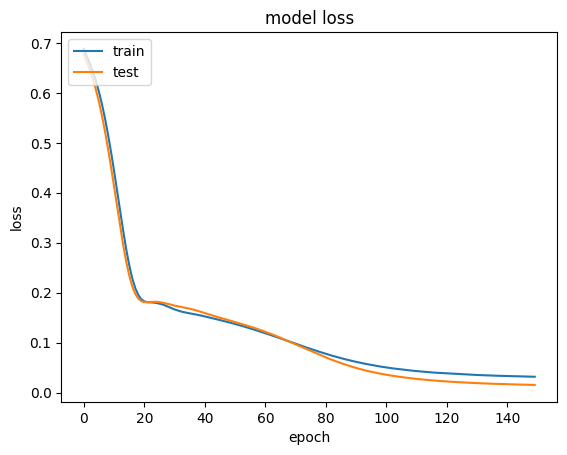

In [61]:
# plot the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [62]:
dfProdi['patterns']

0       sistem informasi
1                     si
2     teknik informatika
3                     ti
4        teknik industri
             ...        
58           ilmu ternak
59                    s2
60    doktor ilmu ternak
61           ilmu ternak
62                    s3
Name: patterns, Length: 63, dtype: object

In [63]:
# display processed vectorizerProdi
dfProdiVector = pd.DataFrame(X, columns=get_feature_names(vectorizerProdi))
# dfProdiVector.index = dfProdi['patterns']
dfProdiVector.style.background_gradient(cmap='gray_r')

c:\Users\AndiAlif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,administrasi,arsitektur,dih,doktor,elektro,fia,fk,geofisika,hukum,ilmu,industri,informasi,informatika,jakarta,kedokteran,kenotariatan,magister,mesin,mih,mkn,negara,niaga,pariwisata,pendidikan,perpajakan,perpustakaan,peternakan,psdku,s1,s2,s3,sarjana,si,sih,sipil,sistem,te,tekdus,teknik,teksip,ternak,ti,tm,ts
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.823245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.567686,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.823245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.567686,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.796763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.604291,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [64]:
def testAllModel(textData):
    print(textData)
    textData = preprocessing_text(textData)

    textDataForSeleksiMasuk = vectorizerSlekMasuk.transform([textData])
    textDataForSeleksiMasuk = textDataForSeleksiMasuk.toarray()

    textDataForFakultas = vectorizerFakultas.transform([textData])
    textDataForFakultas = textDataForFakultas.toarray()

    textDataForProdi = vectorizerProdi.transform([textData])
    textDataForProdi = textDataForProdi.toarray()

    pred = modelForSeleksiMasuk.predict(textDataForSeleksiMasuk)
    pred = np.argmax(pred, axis=1)
    pred = label_encoderSeleksiMasuk.inverse_transform(pred)
    print("seleksi masuk", pred)

    pred = modelForFakultas.predict(textDataForFakultas)
    pred = np.argmax(pred, axis=1)
    pred = label_encoderFakultas.inverse_transform(pred)
    print("fakultas", pred)

    pred = modelForProdi.predict(textDataForProdi)
    pred = np.argmax(pred, axis=1)
    pred = label_encoderProdi.inverse_transform(pred)
    print("prodi", pred)

In [65]:
textData = 'Selamat siang, saya Andi Alifsyah ingin mendaftar di ilmu komputer prodi teknik informatika, saya ingin mengetahui informasi terkait penerimaan mahasiswa baru di Universitas Brawijaya untuk jalur utbk'
testAllModel(textData)

print("---------------")

textData = 'Selamat siang, saya ingin bertanya mengenai daftar ulang bagi mahasiswa kedokteran'
testAllModel(textData)


Selamat siang, saya Andi Alifsyah ingin mendaftar di ilmu komputer prodi teknik informatika, saya ingin mengetahui informasi terkait penerimaan mahasiswa baru di Universitas Brawijaya untuk jalur utbk
1/1 [==============================] - 0s 88ms/step
seleksi masuk ['afirmasi']
1/1 [==============================] - 0s 83ms/step
fakultas ['ft']
1/1 [==============================] - 0s 70ms/step
prodi ['teknik informatika']
---------------
Selamat siang, saya ingin bertanya mengenai daftar ulang bagi mahasiswa kedokteran
1/1 [==============================] - 0s 23ms/step
seleksi masuk ['snmptn']
1/1 [==============================] - 0s 25ms/step
fakultas ['fk']
1/1 [==============================] - 0s 23ms/step
prodi ['kedokteran']


# Model Training

In [77]:
DATASET_UMUM_URL = "https://raw.githubusercontent.com/AndiAlifs/sistem_cerdas_chatbot_selma/master/ori_dataset/Dataset%20-%20Umum.csv"
DATASET_S1_URL = "https://raw.githubusercontent.com/AndiAlifs/sistem_cerdas_chatbot_selma/master/ori_dataset/Dataset%20-%20S1.csv"
DATASET_DIPLOMA_URL = "https://raw.githubusercontent.com/AndiAlifs/sistem_cerdas_chatbot_selma/master/ori_dataset/Dataset%20-%20D3_D4.csv"

In [81]:
dataset_s1 = pd.read_csv(DATASET_S1_URL)
dataset_diploma = pd.read_csv(DATASET_DIPLOMA_URL)
dataset_umum = pd.read_csv(DATASET_UMUM_URL)

In [82]:
dataset_s1.head()

,intent,link_atau_teks,jenjang,Jalurmasuk,fakultas,prodi,tahun,ket,judul,pattern,response
0,tes_kesehatan,https://selma.ub.ac.id/tes-kesehatan-dan-tes-p...,S1,mandiri,FK,Umum,2021,link,Tes Kesehatan dan Psikologi Calon Mahasiswa Ba...,bagaimana tes kesehatan untuk mahasiswa fk jal...,informasi terkait Tes Kesehatan dan Psikologi ...
1,tes_kesehatan,https://selma.ub.ac.id/tes-kesehatan-dan-tes-p...,S1,mandiri,FKG,Umum,2021,link,Tes Kesehatan dan Psikologi Calon Mahasiswa Ba...,bagaimana tes kesehatan untuk mahasiswa fkg ja...,informasi terkait Tes Kesehatan dan Psikologi ...
2,tes_kesehatan,https://selma.ub.ac.id/tes-kesehatan-dan-tes-p...,S1,mandiri,FKH,Umum,2021,link,Tes Kesehatan dan Psikologi Calon Mahasiswa Ba...,bagaimana tes kesehatan untuk mahasiswa fkh ja...,informasi terkait Tes Kesehatan dan Psikologi ...
3,daftar_ulang,https://selma.ub.ac.id/pengumuman-tata-cara-re...,S1,afirmasi,umum,Umum,2022,link,Pengumuman Tata Cara Registrasi Daftar Ulang M...,bagaimana mekanisme daftar ulang jalur afirmas...,informasi terkait Pengumuman Tata Cara Registr...
4,perpanjangan_pembayaran_biaya_pendidikan,https://selma.ub.ac.id/pengumuman-perpanjangan...,S1,umum,umum,Umum,2022,link,Pengumuman Perpanjangan Biaya Proporsional IPI...,bagaimana cara mengajukan perpanjangan biaya p...,informasi terkait Pengumuman Perpanjangan Biay...


In [83]:
dataset_diploma.head()

,intent,link_atau_teks,jenjang,Jalurmasuk,fakultas,prodi,tahun,ket,judul,pattern,respon
0,pengumuman_seleksi,https://selma.ub.ac.id/pengumuman-seleksi-mand...,D3,mandiri_nilai_rapor_dan_nilai_utbk,Vokasi,Umum,2021,link,Pengumuman Seleksi Mandiri Program Vokasi D3 2...,bagaimana syarat penerimaan mahasiswa baru mel...,Informasi terkait Pengumuman Seleksi Mandiri P...
1,pengumuman_seleksi,https://selma.ub.ac.id/pengumuman-seleksi-mand...,D4,mandiri_nilai_rapor_dan_nilai_utbk,Vokasi,Umum,2021,link,Pengumuman Seleksi Mandiri Program Vokasi D4 2...,bagaimana syarat penerimaan mahasiswa baru mel...,Informasi terkait Pengumuman Seleksi Mandiri P...
2,penetapan_biaya_pendidikan,https://selma.ub.ac.id/penetapan-biaya-pendidi...,D3,mandiri_nilai_rapor_dan_nilai_utbk,Vokasi,Umum,2021,link,Penetapan Biaya Pendidikan Proporsional Seleks...,bagaimana cara mengetahui biaya pendidikan pro...,Informasi terkait Penetapan Biaya Pendidikan P...
3,penetapan_biaya_pendidikan,https://selma.ub.ac.id/penetapan-biaya-pendidi...,D4,mandiri_nilai_rapor_dan_nilai_utbk,Vokasi,Umum,2021,link,Penetapan Biaya Pendidikan Proporsional Seleks...,bagaimana cara mengetahui biaya pendidikan pro...,Informasi terkait Penetapan Biaya Pendidikan P...
4,tata_cara_registrasi,https://selma.ub.ac.id/hasil-seleksi-dan-tata-...,D3,prestasi,Vokasi,Umum,2021,link,Hasil Seleksi dan Tata Cara Registrasi Daftar ...,dimana bisa melihat pengumuman penerimaan d3 j...,Informasi terkait Hasil Seleksi dan Tata Cara ...


In [84]:
dataset_umum.head()

,intent,link_atau_teks,jenjang,Jalurmasuk,fakultas,prodi,tahun,ket,judul,pattern,response
0,konfirmasi_pembayaran,Anda harus melakukan konfirmasi manual dengan ...,umum,umum,umum,umum,2019.0,teks,Konfirmasi Pembayaran Uang Kuliah Tunggal,bagaimana cara konfirmasi pembayaran ukt;apa i...,Anda harus melakukan konfirmasi manual dengan ...
1,sanksi_tidak_daftar_ulang,Sanksi bila tidak melakukan Registrasi Adminis...,Umum,Umum,Umum,Umum,NaN,teks,Sanksi Bila Tidak Melakukan Registrasi Adminis...,bagaimana jika tidak melakukan daftar ulang;ap...,Sanksi bila tidak melakukan Registrasi Adminis...


In [85]:
intentsAll = {}

for i in range(len(dataset_s1)):
    intentName = dataset_s1['intent'][i]
    jenjang = dataset_s1['jenjang'][i]
    jalur_masuk = dataset_s1['Jalurmasuk'][i]
    fullIntentName = intentName + "_" + jenjang + "_" + jalur_masuk
    fullIntentName = fullIntentName.replace(" ", "_")
    responses = dataset_s1['response'][i]
    pattern = dataset_s1['pattern'][i]
    allPattern = pattern.split(";")
    newIntent = {
        "tag": fullIntentName,
        "patterns": allPattern,
        "responses": responses
    }
    intentsAll[fullIntentName] = newIntent

for i in range(len(dataset_umum)):
    intentName = dataset_umum['intent'][i]
    jenjang = dataset_umum['jenjang'][i]
    jalur_masuk = dataset_umum['Jalurmasuk'][i]
    fullIntentName = intentName + "_" + jenjang + "_" + jalur_masuk
    fullIntentName = fullIntentName.replace(" ", "_")
    responses = dataset_umum['response'][i]
    pattern = dataset_umum['pattern'][i]
    allPattern = pattern.split(";")
    newIntent = {
        "tag": fullIntentName,
        "patterns": allPattern,
        "responses": responses
    }
    intentsAll[fullIntentName] = newIntent

for i in range(len(dataset_diploma)):
    intentName = dataset_diploma['intent'][i]
    jenjang = dataset_diploma['jenjang'][i]
    jalur_masuk = dataset_diploma['Jalurmasuk'][i]
    fullIntentName = intentName + "_" + jenjang + "_" + jalur_masuk
    fullIntentName = fullIntentName.replace(" ", "_")
    responses = dataset_diploma['respon'][i]
    pattern = dataset_diploma['pattern'][i]
    allPattern = pattern.split(";")
    newIntent = {
        "tag": fullIntentName,
        "patterns": allPattern,
        "responses": responses
    }
    intentsAll[fullIntentName] = newIntent


## Preprocessing data

In [86]:
from nltk.corpus import stopwords

#stopword removal bahasa indonesia
STOPWORDS = set(stopwords.words('indonesian'))

def preprocessing_text(text):
    # lowercase
    text = text.lower()
    # remove number
    text = re.sub(r'\d+', '', text)
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # remove whitespace leading & trailing
    text = text.strip()
    # remove multiple whitespace into single whitespace
    text = re.sub('\s+',' ', text)
    # remove stopword
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    return text

## Preparing data

In [87]:
DOC_X = []
DOC_Y = []

for intent in intentsAll:
    for pattern in intentsAll[intent]['patterns']:
        text = preprocessing_text(pattern)
        DOC_X.append(text)
        DOC_Y.append(intentsAll[intent]['tag'])

In [88]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

vectorizer = TfidfVectorizer()
vectorizer.fit(DOC_X)
DOC_X = vectorizer.transform(DOC_X)
DOC_X = DOC_X.toarray()

label_encoder = OneHotEncoder()
label_encoder.fit(np.array(DOC_Y).reshape(-1, 1))

DOC_Y = label_encoder.transform(np.array(DOC_Y).reshape(-1, 1))
DOC_Y = DOC_Y.toarray()

In [89]:
# show the vectorizer
dfModelVector = pd.DataFrame(DOC_X, columns=vectorizer.get_feature_names())
dfModelVector['intent'] = label_encoder.inverse_transform(DOC_Y)
cols = dfModelVector.columns.tolist()
cols = cols[-1:] + cols[:-1]
dfModelVector = dfModelVector[cols]
dfModelVector.style.background_gradient(cmap='gray_r')

c:\Users\AndiAlif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [96]:
dfModelVector.to_csv('preprocessed_dataset_intent.csv', index=False)

# Modelling the data

In [90]:
import random

X_train = DOC_X
Y_train = DOC_Y

## Modelling using DNN

In [91]:
# Training model using deep neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(256, input_dim=DOC_X.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(DOC_Y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, 
            Y_train,
            epochs=100, 
            batch_size=8)

Epoch 1/100
25/25 [==============================] - 2s 4ms/step - loss: 3.6193 - accuracy: 0.0615
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 3.4750 - accuracy: 0.3538
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 3.2508 - accuracy: 0.4923
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 2.8499 - accuracy: 0.5744
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 2.2912 - accuracy: 0.5795
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 1.7083 - accuracy: 0.6308
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 1.2799 - accuracy: 0.6974
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.9903 - accuracy: 0.6564
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss: 0.8143 - accuracy: 0.7077
Epoch 10/100
25/25 [==============================] - 0s 3ms/step - loss: 0.7283 - accuracy: 0.7128
Epoch 11/

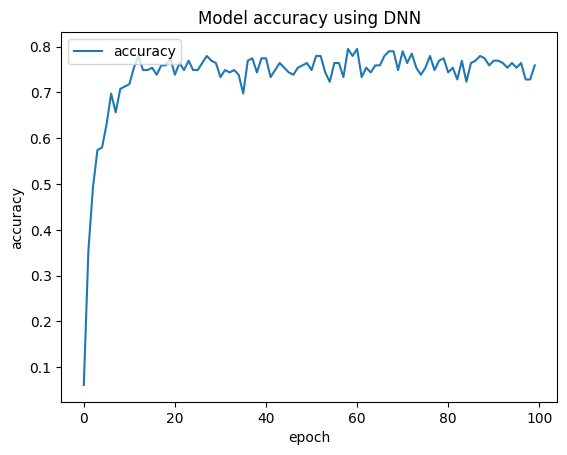

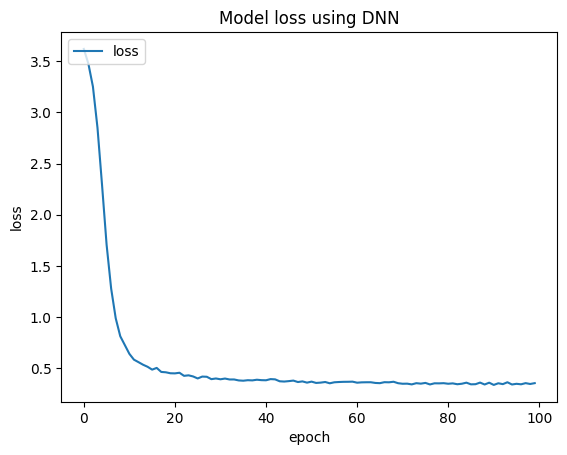

In [92]:
#plot accuracy
import matplotlib.pyplot as plt

plt.title('Model accuracy using DNN')
plt.plot(model.history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc='upper left')
plt.show()

# plot loss
plt.title('Model loss using DNN')
plt.plot(model.history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

## Modelling using LSTM

In [93]:
#training the model using LSTM
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(256, input_shape=(1, DOC_X.shape[1]), return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(DOC_Y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train.reshape(X_train.shape[0], 1, X_train.shape[1]),
            Y_train,
            epochs=100,
            batch_size=8)

Epoch 1/100
25/25 [==============================] - 8s 10ms/step - loss: 3.6386 - accuracy: 0.0308
Epoch 2/100
25/25 [==============================] - 0s 9ms/step - loss: 3.6322 - accuracy: 0.1846
Epoch 3/100
25/25 [==============================] - 1s 28ms/step - loss: 3.6117 - accuracy: 0.3026
Epoch 4/100
25/25 [==============================] - 0s 12ms/step - loss: 3.4829 - accuracy: 0.2000
Epoch 5/100
25/25 [==============================] - 0s 13ms/step - loss: 3.0460 - accuracy: 0.1385
Epoch 6/100
25/25 [==============================] - 0s 14ms/step - loss: 2.5486 - accuracy: 0.2667
Epoch 7/100
25/25 [==============================] - 0s 14ms/step - loss: 2.1084 - accuracy: 0.3949
Epoch 8/100
25/25 [==============================] - 1s 31ms/step - loss: 1.7337 - accuracy: 0.4718
Epoch 9/100
25/25 [==============================] - 1s 27ms/step - loss: 1.4297 - accuracy: 0.5538
Epoch 10/100
25/25 [==============================] - 0s 14ms/step - loss: 1.2275 - accuracy: 0.6051


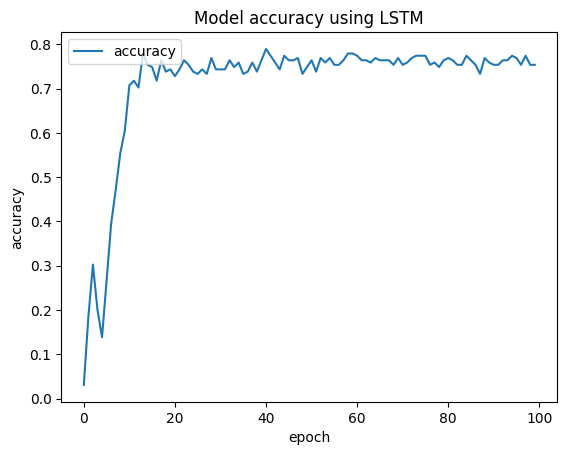

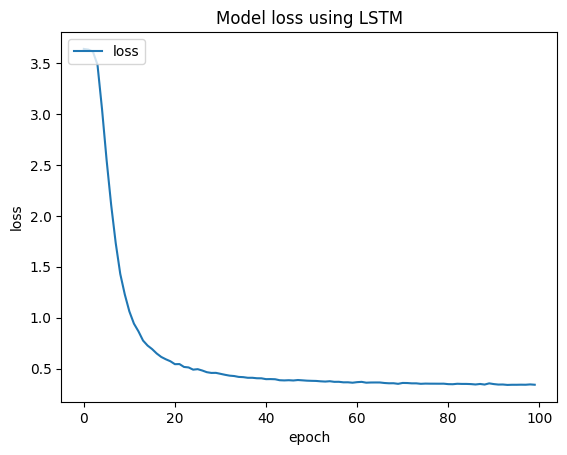

In [94]:
#plot accuracy
import matplotlib.pyplot as plt

plt.title('Model accuracy using LSTM')
plt.plot(model.history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc='upper left')
plt.show()

# plot loss
plt.title('Model loss using LSTM')
plt.plot(model.history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()